# Implementing a Recommender System using LightGCN

In [24]:
import matplotlib.pyplot as plt
from modeling.sampling import sample_minibatch_V2
from modeling.metrics import calculate_metrics, generate_ground_truth_mapping
from modeling.losses import BPR_loss
from modeling.models.lightGCN import LightGCN
import torch.nn.functional as F
import torch_geometric.transforms as T

import time

import torch
from torch import optim

In [25]:
# Lets start by loading the data
data = torch.load("data/hetero_data_filtered_3_2.pt", weights_only=False)
assert data.is_undirected(), "Data should be undirected"
# data["author"].x = torch.ones((data["author"].num_nodes, 256))

data = T.ToUndirected()(data)
data = T.AddSelfLoops()(data)
data = T.NormalizeFeatures()(data)

print(data)

HeteroData(
  author={
    node_id=[20950],
    x=[20950, 256],
  },
  paper={
    node_id=[39802],
    x=[39802, 256],
  },
  (author, writes, paper)={ edge_index=[2, 185956] },
  (paper, rev_writes, author)={ edge_index=[2, 185956] },
  (author, rev_rev_writes, paper)={ edge_index=[2, 185956] }
)


In [26]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=False,
    is_undirected=True,
    edge_types=[("author", "writes", "paper")],
    rev_edge_types=[("paper", "rev_writes", "author")],
)(data)

In [27]:
edge_author_ids = train_data["author", "writes", "paper"].edge_index[0]
edge_paper_ids = train_data["author", "writes", "paper"].edge_index[1]

unique_edge_author_ids = torch.unique(edge_author_ids)
unique_edge_paper_ids = torch.unique(edge_paper_ids)
print(f"Min_author_id: {unique_edge_author_ids.min().item()}, Max_author_id: {unique_edge_author_ids.max().item()}, Num unique author ids: {unique_edge_author_ids.size(0)}")
print(f"Min_paper_id: {unique_edge_paper_ids.min().item()}, Max_paper_id: {unique_edge_paper_ids.max().item()}, Num unique paper ids: {unique_edge_paper_ids.size(0)}")

Min_author_id: 0, Max_author_id: 20949, Num unique author ids: 19830
Min_paper_id: 1, Max_paper_id: 39801, Num unique paper ids: 38143


In [28]:
# define contants
ITERATIONS = 10000
LR = 1e-3

ITERS_PER_EVAL = 1000
K = 20

BATCH_SIZE = 4096 * 16
NEG_SAMPLE_RATIO = 10

TEST_EDGE_TYPE = ("author", "writes", "paper")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}.")

Using device cuda.


In [29]:
# setup
model = LightGCN(
    num_authors=data["author"].num_nodes,
    num_papers=data["paper"].num_nodes,
    embedding_dim=256,
    K=3,
)
model = model.to(device)
model.train()

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

train_message_passing_edge_index = train_data[TEST_EDGE_TYPE].edge_index
train_supervision_edge_index = train_data[TEST_EDGE_TYPE].edge_label_index
train_edge_index = train_data[TEST_EDGE_TYPE].edge_index
val_edge_index = val_data[TEST_EDGE_TYPE].edge_label_index
test_edge_index = test_data[TEST_EDGE_TYPE].edge_label_index

optimizer = optim.Adam(model.parameters(), lr=LR)

# training loop
train_losses = []
batching_times = []
forward_times = []
loss_times = []
backward_times = []

In [ ]:
for iter in range(ITERATIONS):
    print(
        f"Iteration {iter + 1}/{ITERATIONS} | Average Loss over last 100 iters: {sum(train_losses[-100:])/len(train_losses[-100:]) if len(train_losses) > 0 else 0:.5f}",
        end="\r",
    )
    # mini batching
    start_time = time.time()
    sampled_author_ids, sampled_pos_paper_ids, sampled_neg_paper_ids = (
        sample_minibatch_V2(
            data=train_data,
            edge_type=TEST_EDGE_TYPE,
            batch_size=BATCH_SIZE,
            neg_sample_ratio=NEG_SAMPLE_RATIO,
        )
    )
    batching_times.append(time.time() - start_time)

    # forward propagation
    start_time = time.time()
    embeddings = model.forward(train_data)
    author_embeddings = embeddings["author"]
    paper_embeddings = embeddings["paper"]
    forward_times.append(time.time() - start_time)

    pos_scores = torch.sum(
        author_embeddings[sampled_author_ids] * paper_embeddings[sampled_pos_paper_ids],
        dim=1,
    )
    neg_scores = torch.sum(
        author_embeddings[sampled_author_ids] * paper_embeddings[sampled_neg_paper_ids],
        dim=1,
    )

    # loss computation
    start_time = time.time()
    train_loss = BPR_loss(pos_scores, neg_scores)
    loss_times.append(time.time() - start_time)

    # backward propagation
    start = time.time()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    backward_times.append(time.time() - start)
    train_losses.append(train_loss.item())

    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            embeddings = model.forward(val_data)
            author_embeddings = embeddings["author"]
            paper_embeddings = embeddings["paper"]


        val_recall, val_precision = calculate_metrics(
            author_embeddings,
            paper_embeddings,
            val_edge_index,
            [train_edge_index],
            K,
        )

        with torch.no_grad():
            embeddings = model.forward(train_data)
            author_embeddings = embeddings["author"]
            paper_embeddings = embeddings["paper"]

        train_recall, train_precision = calculate_metrics(
            author_embeddings,
            paper_embeddings,
            train_supervision_edge_index,
            [train_message_passing_edge_index],
            K,
        )

        print(
            f"[Iteration {iter + 1}/{ITERATIONS}] train_loss: {train_loss.item():.05f}, val_recall@{K}: {val_recall:.05f}, train_recall@{K}: {train_recall:.05f}"
        )
        model.train()

[Iteration 1/10000] train_loss: 0.69320, val_recall@20: 0.00041, train_recall@20: 0.00080
[Iteration 1001/10000] train_loss: 0.01022, val_recall@20: 0.09110, train_recall@20: 0.99849
[Iteration 2001/10000] train_loss: 0.00215, val_recall@20: 0.09384, train_recall@20: 0.99847
[Iteration 3001/10000] train_loss: 0.00091, val_recall@20: 0.09500, train_recall@20: 0.99848
[Iteration 4001/10000] train_loss: 0.00051, val_recall@20: 0.09608, train_recall@20: 0.99850
[Iteration 5001/10000] train_loss: 0.00033, val_recall@20: 0.09628, train_recall@20: 0.99851
[Iteration 6001/10000] train_loss: 0.00026, val_recall@20: 0.09633, train_recall@20: 0.99851


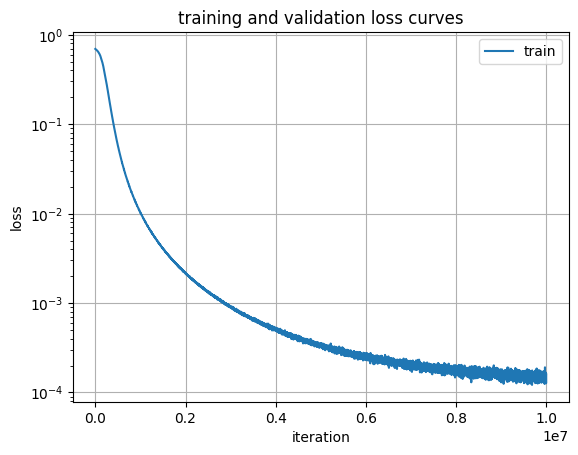

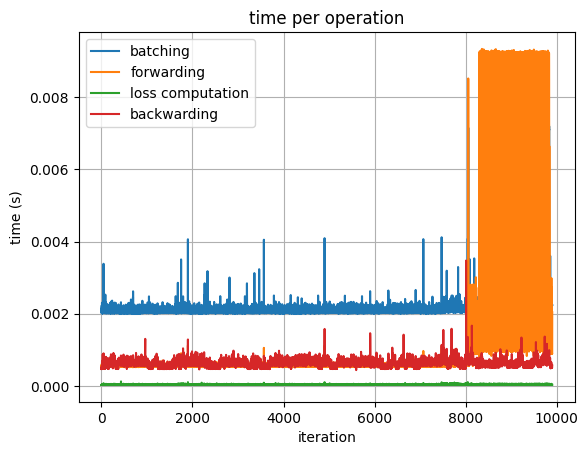

In [ ]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label="train")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.yscale("log")
plt.title("training and validation loss curves")
plt.legend()
plt.grid()
plt.show()

plt.plot(batching_times[100:], label="batching")
plt.plot(forward_times[100:], label="forwarding")
plt.plot(loss_times[100:], label="loss computation")
plt.plot(backward_times[100:], label="backwarding")
plt.xlabel("iteration")
plt.ylabel("time (s)")
plt.title("time per operation")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# [test_recall@20: 0.05323, test_precision@20: 0.00412

model.eval()
test_edge_index = test_edge_index.to(device)

with torch.no_grad():
    embeddings = model.forward(train_data)
    author_embeddings = embeddings["author"]
    paper_embeddings = embeddings["paper"]

    test_recall, test_precision = calculate_metrics(
        author_embeddings,
        paper_embeddings,
        test_edge_index,
        [train_edge_index, val_edge_index],
        K,
        batch_size=1024,
    )

print(
    f"[test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}"
)

[test_recall@20: 0.09548, test_precision@20: 0.00802


In [ ]:
torch.save(model.state_dict(), "lightgcn_model.pt")

In [ ]:
with torch.no_grad():
    user_embeddings, item_embeddings = model.get_embeddings(train_message_passing_edge_index)

AttributeError: 'LightGCN' object has no attribute 'get_embeddings'

In [ ]:
def calculate_metrics_2(
    user_embedding: torch.Tensor,
    item_embedding: torch.Tensor,
    edge_index: torch.Tensor,
    exclude_edge_indices: list[torch.Tensor],
    k: int = 20,
    batch_size=1024,
    device=None,
):
    user_ids = edge_index[0].unique()
    num_user_ids = user_ids.shape[0]

    # This mapping is taking the most time!
    user_id_to_ground_truth_ids = generate_ground_truth_mapping(edge_index)
    ###################################

    exclude_user_id_to_ground_truth_ids = [
        generate_ground_truth_mapping(exclude_edge_index)
        for exclude_edge_index in exclude_edge_indices
    ]

    # The top K indices tensor is a [num_users, K] tensor
    # It contains for each user the top K item indices predicted by the model
    # the order is from most to least relevant in the 20 recommendations
    # Be aware that the tensor is indexed, not by the user id itself, but by the position of the user id in the user_ids tensor
    top_K_indices = torch.empty((num_user_ids, k), dtype=torch.long, device=device)
    for start in range(0, num_user_ids, batch_size):
        # We fist get the batched user ids, we could technically do all in one step by doing a big matrix multiplication
        # But this would require too much memory, this is the reason for batching
        batched_user_ids = user_ids[start : start + batch_size]

        # Then we get the embeddings for the batched user ids, we index each user embedding by the user id
        # we made sure that the user IDs are starting at 0 and end at num_users - 1, so no ID is empty
        batched_user_embeddings = user_embedding[batched_user_ids]

        # Now we appyl our decoder, this is the dot product between user and item embeddings
        # For models which use non standard decoders we can not do this, but all our current models do use this simple decoder
        # Teh result is a [batch_size, num_items] tensor where each entry is the score for that user-item combination
        batched_scores = torch.matmul(batched_user_embeddings, item_embedding.T)

        # Now we need to mask out all user-item interactions that are already known from the exclude set
        # These could be edges which are the supervision edges used during training
        # When we would keep these, we would artifically lower our score as they would be treated as top recommendations i.e. False Positives
        for batch_index, user_id in enumerate(batched_user_ids.tolist()):
            seen_items = set()
            for exclude_set in exclude_user_id_to_ground_truth_ids:
                seen_items.update(exclude_set.get(user_id, set()))

            if seen_items:
                batched_scores[batch_index, list(seen_items)] = -1e9

        # Now we get the top K indices for each user in the batch
        # We then directly store them in the preallocated top_K_indices tensor
        # This is indexed by the user ids in the batch
        _, top_K_indices[start : start + batch_size] = torch.topk(
            batched_scores,
            k=k,
            dim=1,
        )
    top_K_indices = top_K_indices.cpu()

    # The top K hits tensor is a [num_users, K] tensor
    # If effectivly functions as "how many of the top K recommendations where actually in the ground truth"
    # For example for K = 5 one example would be:
    # user 4: [0, 1, 0, 0, 1] means that for user 4 the items at index 1 and 4 in the top K where in the ground truth, all others where not
    # We repeat this for all users to get a [num_users, K] tensor
    top_K_hits = torch.empty((num_user_ids, k), dtype=torch.float32)
    for user_index, user_id in enumerate(user_ids.tolist()):
        # First we retrieve the ground truth indices for that user by looking it up in the dictionary we created earlier
        ground_truth_indices = user_id_to_ground_truth_ids[user_id]

        # Now we create the hit vector for that user
        # This is as easy as iterating over the top K indices and checking if the given item id appears in the ground truth
        # see `int(i in ground_truth_indices)`, this evaluates to 1 if true, 0 if false
        # We just do that for all the items for a given user
        top_K_hits[user_index] = torch.tensor(
            [
                int(i in ground_truth_indices)
                for i in top_K_indices[user_index].tolist()
            ],
            dtype=torch.float32,
        )
        
    ground_truth_indicies = [
        user_id_to_ground_truth_ids[user_id.item()] for user_id in user_ids
    ]

    return top_K_hits, ground_truth_indicies 

In [ ]:
model.eval()

with torch.no_grad():
    # typically we would use the supervising edges as well here
    # But LightGCN does not have parameters, it only learns from the edges we use during training is is fix after that
    user_embedding, item_embedding = model.get_embeddings(
        train_message_passing_edge_index
    )

top_K_hits, ground_truth_indicies = calculate_metrics_2(
    user_embedding,
    item_embedding,
    test_edge_index,
    [train_edge_index, val_edge_index],
    K,
    batch_size=1024,
)

num_correct_per_user = top_K_hits.sum(dim=1)
num_relevant_per_user = torch.tensor(
    [len(ground_truth_indicies[i]) for i in range(len(ground_truth_indicies))],
    dtype=torch.float32,
)

recall_per_user = num_correct_per_user / num_relevant_per_user
recall = recall_per_user.mean().item()

print(f"Recall@{K} on train set: {recall:.5f}")
print(torch.sum(num_correct_per_user > 0))
print(torch.sum(num_correct_per_user == 0))

plt.hist(recall_per_user.numpy())
plt.yscale("log")